In [7]:
import numpy as np

import matplotlib
%matplotlib inline

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
from run_inference import load_inference_results, print_inference_summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

## Compute and Plot Likelihood Grid


In [3]:
# Set up paths and parameters for likelihood grid computation
import sys
import os
sys.path.append('../code')

# Define file paths (same parameters as main inference)
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
f_agn = 0.5
lambda_agn = 0.5
N_gw = 1000
seed = 42
gw_seed = 1042
nside = 64

tag_mock_extra = f'_bgal{bias_gal}_bagn{bias_agn}'
tag_mock = f'_seed{seed}_ratioNgalNagn{ratioNgalNagn}{tag_mock_extra}'
dir_mock = f'../data/mocks_glass/mock{tag_mock}'
galaxy_file = os.path.join(dir_mock, f'lognormal_pixelated_nside_{nside}_galaxies.h5')
agn_file = os.path.join(dir_mock, f'lognormal_pixelated_nside_{nside}_agn.h5')
gw_file = os.path.join(dir_mock, f'gwsamples_fagn{f_agn}_lambdaagn{lambda_agn}_N{N_gw}_seed{gw_seed}_pos_only.h5')

print(f"Galaxy file: {galaxy_file}")
print(f"AGN file: {agn_file}")
print(f"GW file: {gw_file}")


Galaxy file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_galaxies.h5
AGN file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_agn.h5
GW file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.5_N1000_seed1042_pos_only.h5


In [4]:
# Load data using functions from run_inference
from run_inference import (
    load_catalog_data, 
    setup_cosmology, 
    create_catalog_probability_functions,
    load_gw_samples,
    compute_darksiren_log_likelihood,
    compute_pixel_indices
)

# Load catalog data
print("Loading catalog data...")
catalog_data = load_catalog_data(galaxy_file, agn_file, nside=nside)

# Setup cosmology
print("Setting up cosmology...")
cosmo_funcs = setup_cosmology()

# Create catalog probability functions
print("Creating catalog probability functions...")
prob_funcs = create_catalog_probability_functions(catalog_data)

# Load GW samples
print("Loading GW samples...")
gw_data = load_gw_samples(gw_file)

print("Data loaded successfully!")


Loading catalog data...
Loading catalog data: galaxy_file=../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_galaxies.h5, agn_file=../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_agn.h5, nside=64
Loaded!
Setting up cosmology...
Setting up cosmology: zMax_1=0.5, zMax_2=5, Om0_range=0.1, n_Om0=100


100%|██████████| 100/100 [00:01<00:00, 56.06it/s]


Creating catalog probability functions...
Creating catalog probability functions: nside=64
Loading GW samples...
Loading GW samples from ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.5_N1000_seed1042_pos_only.h5 (nEvents=None, nsamp=None)
Data loaded successfully!


In [5]:

# Set default parameters
Om0 = cosmo_funcs['Om0Planck']
gamma_agn = 0
gamma_gal = 0

# Precompute pixel indices once (they don't depend on H0, f, Om0, or gammas)
print("Precomputing pixel indices...")
samples_ind = compute_pixel_indices(gw_data['ra'], gw_data['dec'], nside)

Precomputing pixel indices...
Computing pixel indices: nside=64, n_samples=10000000


In [6]:
dL = gw_data['dL']
p_pe = gw_data['p_pe']
nEvents = gw_data['nEvents']
nsamp = gw_data['nsamp']

z_of_dL = cosmo_funcs['z_of_dL']
ddL_of_z = cosmo_funcs['ddL_of_z']
logPriorUniverse = prob_funcs['logPriorUniverse']

In [7]:
H0 = 70
print(f"Computing redshifts: dL={dL}, H0={H0}, Om0={Om0}")
z = z_of_dL(dL, H0, Om0)

Computing redshifts: dL=[3801.8677 3896.6191 3727.3782 ... 7477.854  7379.38   7648.6797], H0=70, Om0=0.3075


In [8]:
ddL_of_z(z, dL, H0, Om0)

Array([7225.9785, 7265.0967, 7194.6333, ..., 8320.486 , 8299.159 ,
       8356.767 ], dtype=float32)

In [9]:
f = 0.5
logPriorUniverse(z, samples_ind, f, Om0, gamma_agn, gamma_gal)

ValueError: Incompatible shapes for broadcasting: shapes=[(10000000,), (10000000, 350), (10000000, 350)]

In [ ]:
# Create parameter grid for likelihood computation

H0_min, H0_max = 20, 120
f_min, f_max = 0, 1
n_H0 = 5
n_f = 5

H0_grid = np.linspace(H0_min, H0_max, n_H0)
f_grid = np.linspace(f_min, f_max, n_f)
H0_mesh, f_mesh = np.meshgrid(H0_grid, f_grid)

print(f"Computing likelihood on grid: {n_H0} x {n_f} = {n_H0*n_f} points")
print(f"H0 range: [{H0_min}, {H0_max}]")
print(f"f range: [{f_min}, {f_max}]")


Computing likelihood on grid: 5 x 5 = 25 points
H0 range: [20, 120]
f range: [0, 1]


In [ ]:
# Compute log-likelihood on grid
log_likelihood_grid = np.zeros((n_f, n_H0))

In [ ]:

print("Computing likelihoods...")
from tqdm import tqdm

for i, f_val in enumerate(tqdm(f_grid)):
    for j, H0_val in enumerate(H0_grid):
        try:
            ll = compute_darksiren_log_likelihood(
                gw_data, catalog_data, cosmo_funcs, prob_funcs,
                H0_val, f_val, samples_ind, Om0=Om0, gamma_agn=gamma_agn, gamma_gal=gamma_gal
            )
            log_likelihood_grid[i, j] = ll
        except:
            log_likelihood_grid[i, j] = np.nan

print("Likelihood computation complete!")


Computing likelihoods...


  0%|          | 0/5 [00:00<?, ?it/s]

Computing dark siren log-likelihood: H0=20.0, f=0.0, Om0=0.3075, gamma_agn=0, gamma_gal=0
Computing redshifts: dL=[3801.8677 3896.6191 3727.3782 ... 7477.854  7379.38   7648.6797], H0=20.0, Om0=0.3075
Computing log weights: z=[0.21946071 0.22431739 0.21562734 ... 0.3951343  0.39070824 0.4027826 ], p_pe=[1. 1. 1. ... 1. 1. 1.], nEvents=1000, nsamp=10000
Reshaping and computing log-likelihood: log_weights=[-8.5439181e+05 -2.3234702e+06 -8.9048538e+05 ... -3.9634927e+03
 -1.4148359e+06 -1.2959634e+06], nEvents=1000, nsamp=10000
Computing dark siren log-likelihood: H0=45.0, f=0.0, Om0=0.3075, gamma_agn=0, gamma_gal=0
Computing redshifts: dL=[3801.8677 3896.6191 3727.3782 ... 7477.854  7379.38   7648.6797], H0=45.0, Om0=0.3075
Computing log weights: z=[0.44273007 0.45199773 0.43540868 ... 0.7748947  0.7665568  0.7893036 ], p_pe=[1. 1. 1. ... 1. 1. 1.], nEvents=1000, nsamp=10000


In [11]:
f_val = 0.5
H0_val = 70
ll = compute_darksiren_log_likelihood(
                gw_data, catalog_data, cosmo_funcs, prob_funcs,
                H0_val, f_val, samples_ind, Om0=Om0, gamma_agn=gamma_agn, gamma_gal=gamma_gal
            )

Computing dark siren log-likelihood: H0=70, f=0.5, Om0=0.3075, gamma_agn=0, gamma_gal=0


In [8]:
dL = gw_data['dL']
z_of_dL = cosmo_funcs['z_of_dL']
H0 = 70
Om0 = cosmo_funcs['Om0Planck']
z = z_of_dL(dL, H0, Om0)

In [ ]:
# Plot likelihood grid as contour plot
fig, ax = plt.subplots(figsize=(10, 8))

# Convert to likelihood (relative, normalized)
likelihood_grid = np.exp(log_likelihood_grid - np.nanmax(log_likelihood_grid))

# Create contour plot
contour_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
CS = ax.contour(H0_mesh, f_mesh, likelihood_grid, levels=contour_levels, 
                colors='black', alpha=0.6, linewidths=1.5)
ax.clabel(CS, inline=True, fontsize=10, fmt='%.1f')

# Fill contours
im = ax.contourf(H0_mesh, f_mesh, likelihood_grid, levels=50, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='Relative Likelihood')

# Mark maximum
max_idx = np.unravel_index(np.nanargmax(log_likelihood_grid), log_likelihood_grid.shape)
H0_max_val = H0_grid[max_idx[1]]
f_max_val = f_grid[max_idx[0]]
ax.plot(H0_max_val, f_max_val, 'r*', markersize=20, label=f'Max: H0={H0_max_val:.1f}, f={f_max_val:.3f}')

ax.set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=14)
ax.set_ylabel(r'$f$', fontsize=14)
ax.set_title(f'Likelihood Grid (N_gw={N_gw}, nside={nside})', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [1]:
# Plot 1D marginal likelihoods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Marginalize over f to get H0 likelihood
H0_likelihood = np.nansum(likelihood_grid, axis=0)
H0_likelihood = H0_likelihood / np.nanmax(H0_likelihood)

axes[0].plot(H0_grid, H0_likelihood, 'b-', linewidth=2)
axes[0].axvline(H0_max_val, color='r', linestyle='--', label=f'Max at {H0_max_val:.1f}')
axes[0].set_xlabel(r'$H_0$ [km/s/Mpc]', fontsize=12)
axes[0].set_ylabel('Relative Likelihood', fontsize=12)
axes[0].set_title('Marginalized over $f$', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Marginalize over H0 to get f likelihood
f_likelihood = np.nansum(likelihood_grid, axis=1)
f_likelihood = f_likelihood / np.nanmax(f_likelihood)

axes[1].plot(f_grid, f_likelihood, 'b-', linewidth=2)
axes[1].axvline(f_max_val, color='r', linestyle='--', label=f'Max at {f_max_val:.3f}')
axes[1].set_xlabel(r'$f$', fontsize=12)
axes[1].set_ylabel('Relative Likelihood', fontsize=12)
axes[1].set_title('Marginalized over $H_0$', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

## Setup and Load inference results

In [14]:
# Define inference results path
ratioNgalNagn = 1
bias_gal = 1.0
bias_agn = 1.0
f_agn = 0.5
lambda_agn = 0.5
N_gw = 1000
seed = 42
gw_seed = 1042

tag_inf = f'_fagn{f_agn}_lambdaagn{lambda_agn}_N{N_gw}_seed{gw_seed}'
output_file = f'../results/inference/inference_results{tag_inf}.h5'


In [15]:
loaded_results = load_inference_results(output_file)
print_inference_summary(loaded_results)

# Load truth values
# Truth values from mock generation parameters
truth_f_agn = f_agn  # f_agn = 0.5 is the true AGN fraction parameter
truth_f = truth_f_agn  # The inferred parameter f corresponds to f_agn
truth_H0 = loaded_results['metadata'].get('H0Planck', 67.74)  # Use H0Planck as truth value

print(f"\nTruth values:")
print(f"  H0 (truth): {truth_H0:.2f} km/s/Mpc")
print(f"  f (truth): {truth_f:.3f}")


Loading inference results from ../results/inference/inference_results_fagn0.5_lambdaagn0.5_N1000_seed1042.h5
Printing inference results summary
Inference Results Summary
Timestamp: 2025-11-26T13:16:47.297788
Number of samples: 12800
Number of parameters: 2

MCMC Parameters:
  $H_0$: [20, 120]
  $f$: [0, 1]

Configuration:
  galaxy_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_galaxies.h5
  agn_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_64_agn.h5
  gw_file: ../data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn0.5_lambdaagn0.5_N1000_seed1042_pos_only.h5
  nside: 64
  nEvents: 100
  nsamp: 10000
  n_walkers: 16
  n_steps: 1000

Metadata:
  H0Planck: 67.74
  Om0Planck: 0.3075
  N_gal: 1176983.0
  N_agn: 1177354.0

Posterior Samples Shape: (12800, 2)
Parameter means:
  $H_0$: 66.7202 ± 5.4916
  $f$: 0.0406 ± 0.0840

Truth values:
  H0 (truth): 67.74 km/s/Mpc
  f (t

In [16]:
# Access data
samples = loaded_results['posterior_samples']
config = loaded_results['config']
metadata = loaded_results['metadata']
mcmc_params = loaded_results.get('mcmc_params', {})
labels = mcmc_params.get('labels', [f'param_{i}' for i in range(samples.shape[1])])

### Plot histograms

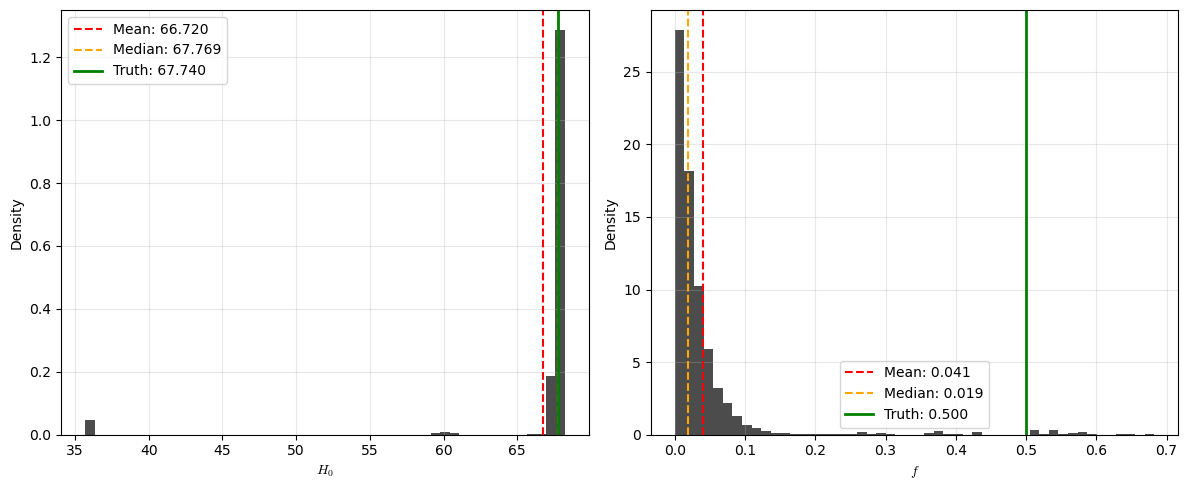

In [17]:
# Plot histograms for each parameter
n_params = samples.shape[1]
fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))

if n_params == 1:
    axes = [axes]

# Truth values array
truth_values = [truth_H0, truth_f]

for i, (ax, label) in enumerate(zip(axes, labels)):
    ax.hist(samples[:, i], bins=50, density=True, alpha=0.7, color='black')
    ax.axvline(np.mean(samples[:, i]), color='red', linestyle='--', 
               label=f'Mean: {np.mean(samples[:, i]):.3f}')
    ax.axvline(np.median(samples[:, i]), color='orange', linestyle='--', 
               label=f'Median: {np.median(samples[:, i]):.3f}')
    # Overplot truth value
    ax.axvline(truth_values[i], color='green', linestyle='-', linewidth=2,
               label=f'Truth: {truth_values[i]:.3f}')
    ax.set_xlabel(label)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Corner plot


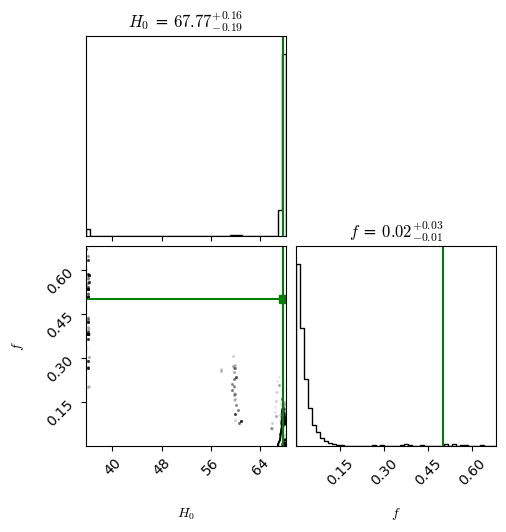

In [18]:
# Corner plot
import corner
fig = corner.corner(samples, labels=labels, show_titles=True, 
                    title_kwargs={"fontsize": 12}, bins=50,
                    truths=[truth_H0, truth_f], truth_color='green', 
                    truth_kwargs={'linestyle': '-', 'linewidth': 2})
plt.show()
